In [66]:
import numpy as np
import matplotlib.pyplot as plt

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_evaluation_results(file_paths, smooth_length=10):
    """
    Plots the evaluation reward and success rate from multiple NPZ files.
    
    - Computes mean and standard deviation for rewards.
    - Computes mean and percentiles (25th & 75th) for success.
    - Converts time from seconds to hours.
    - Smooths the curves using a moving average.
    - Displays both plots side by side.
    
    Parameters:
        file_paths (list): List of NPZ file paths.
        smooth_length (int): Window size for smoothing the data.
    """

    # Load data
    time_lists, reward_lists, success_lists = [], [], []

    for file_path in file_paths:
        data = np.load(file_path)
        time_lists.append(data["Total_Time_List"] / 3600)  # Convert seconds to hours
        reward_lists.append(data["Evaluation_Reward_List"])
        success_lists.append(data["Evaluation_Success_List"])

    # Create a common time axis (longest duration)
    max_time = max(t[-1] for t in time_lists)  # Last time point across datasets
    num_points = max(len(t) for t in time_lists)  # Keep enough resolution
    time_common = np.linspace(0, max_time, num_points)

    # Interpolate all data onto the common time axis
    reward_interp, success_interp = [], []

    for i in range(len(file_paths)):
        reward_interp.append(interp1d(time_lists[i], reward_lists[i], kind='linear', fill_value="extrapolate")(time_common))
        success_interp.append(interp1d(time_lists[i], success_lists[i], kind='linear', fill_value="extrapolate")(time_common))

    # Convert lists to numpy arrays
    reward_interp = np.array(reward_interp)
    success_interp = np.array(success_interp)

    # Compute mean and variance for rewards
    reward_mean = np.mean(reward_interp, axis=0)
    reward_std = np.std(reward_interp, axis=0)

    # Compute mean and percentiles for success rate
    success_mean = np.mean(success_interp, axis=0)
    success_25 = np.percentile(success_interp, 25, axis=0)
    success_75 = np.percentile(success_interp, 75, axis=0)

    # Smoothing function
    def smooth(data, length):
        pad = np.repeat(data[0], length - 1)  # Padding with the first value
        pad_data = np.concatenate((pad, data))
        smoothed = np.array([np.mean(pad_data[i:i + length]) for i in range(len(data))])
        return smoothed

    # Apply smoothing
    reward_mean_smooth = smooth(reward_mean, smooth_length)
    reward_std_smooth = smooth(reward_std, smooth_length)
    success_mean_smooth = smooth(success_mean, smooth_length)
    success_25_smooth = smooth(success_25, smooth_length)
    success_75_smooth = smooth(success_75, smooth_length)

    # Plot both figures in one figure (side by side)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Evaluation Reward over Time
    axes[0].plot(time_common, reward_mean_smooth, label="Mean Reward", linewidth=3, linestyle="--", color="blue")
    axes[0].fill_between(time_common, reward_mean_smooth + reward_std_smooth, reward_mean_smooth - reward_std_smooth, alpha=0.2, color="blue")
    axes[0].set_xlabel("Time (hours)")
    axes[0].set_ylabel("Reward")
    axes[0].set_title("Smoothed Evaluation Reward")
    axes[0].legend()
    axes[0].grid(True)

    # Plot Evaluation Success over Time with Percentiles
    axes[1].plot(time_common, success_mean_smooth, label="Mean Success", linewidth=3, linestyle="--", color="green")
    axes[1].fill_between(time_common, success_25_smooth, success_75_smooth, alpha=0.2, color="green")
    axes[1].set_xlabel("Time (hours)")
    axes[1].set_ylabel("Success Rate")
    axes[1].set_title("Smoothed Evaluation Success")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


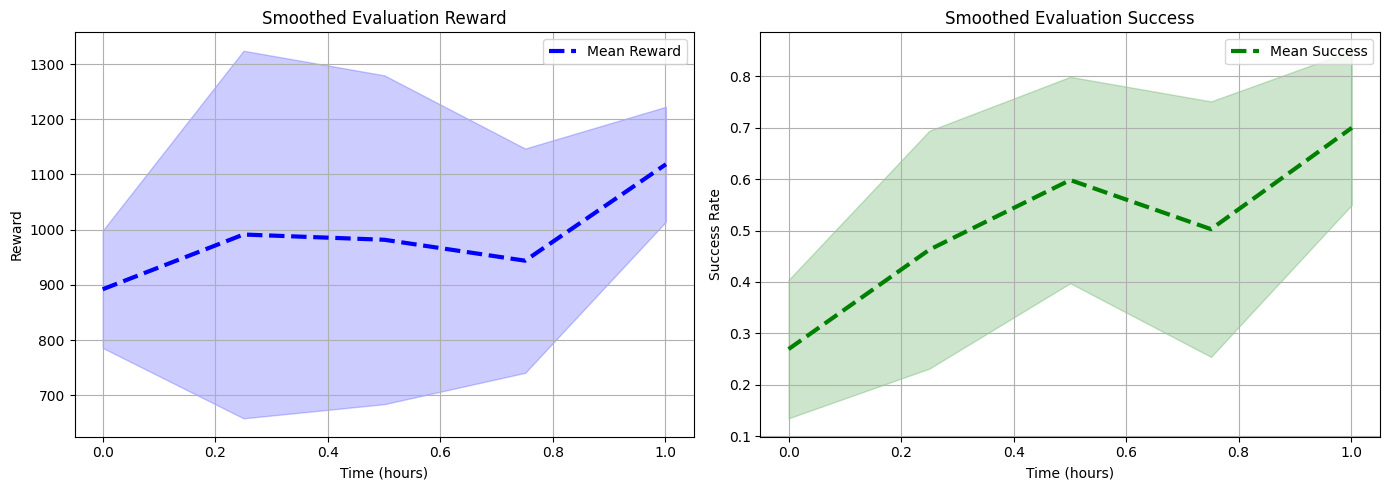

In [68]:
# Example usage
file_paths = [
    "./results/eval_ExpD3_64_128_2_0.npz",
    "./results/eval_ExpD3_64_128_2_2.npz",
]
#plot_evaluation_results(file_paths[:1], smooth_length=10)
#plot_evaluation_results(file_paths[1:2], smooth_length=10)
#plot_evaluation_results(file_paths[2:3], smooth_length=1)
#plot_evaluation_results(file_paths[3:4], smooth_length=10)
plot_evaluation_results(file_paths, smooth_length=1)

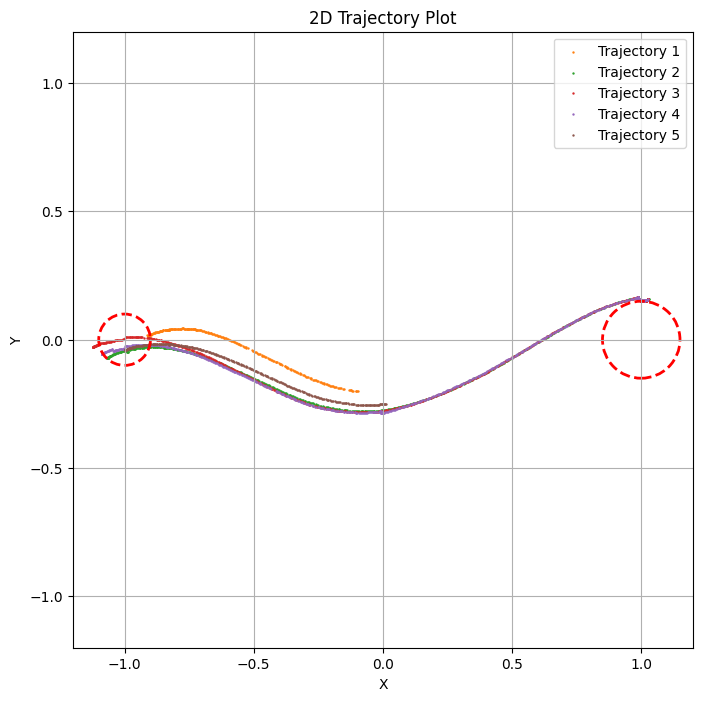

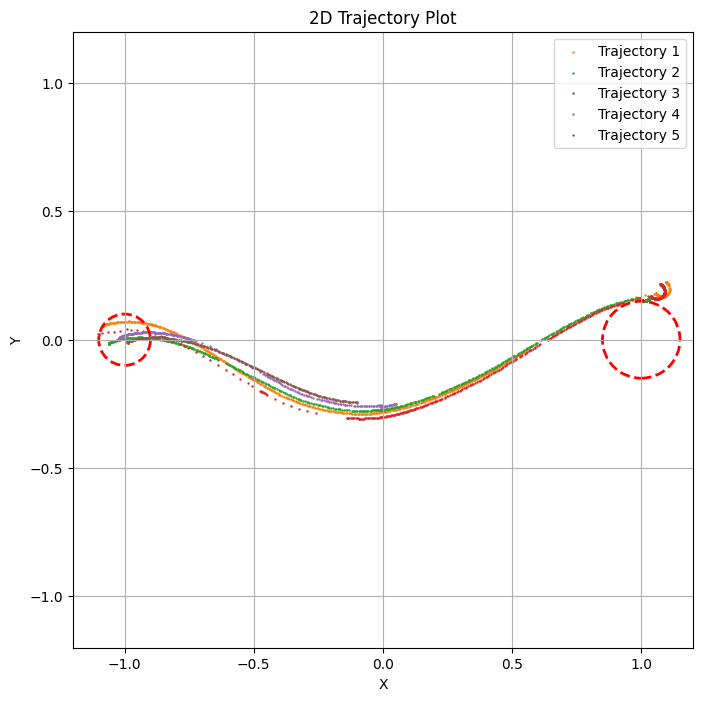

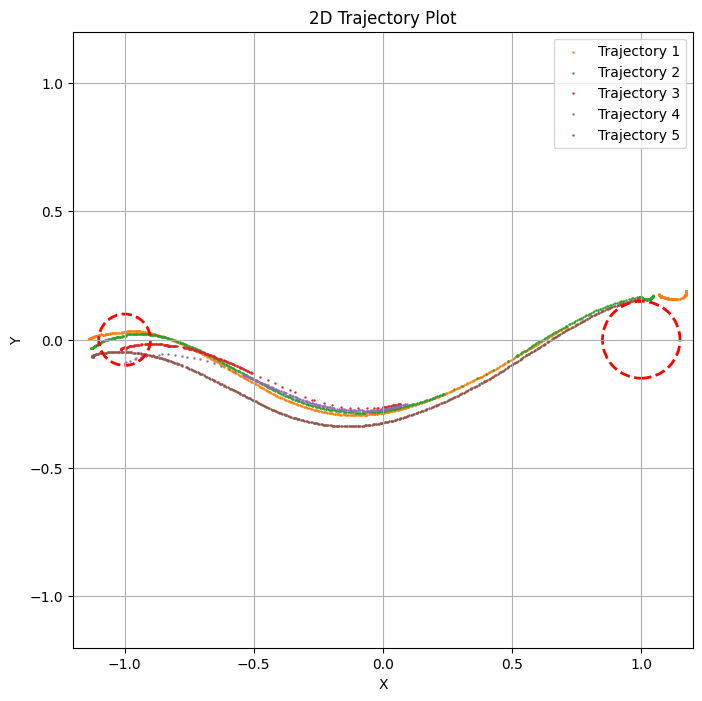

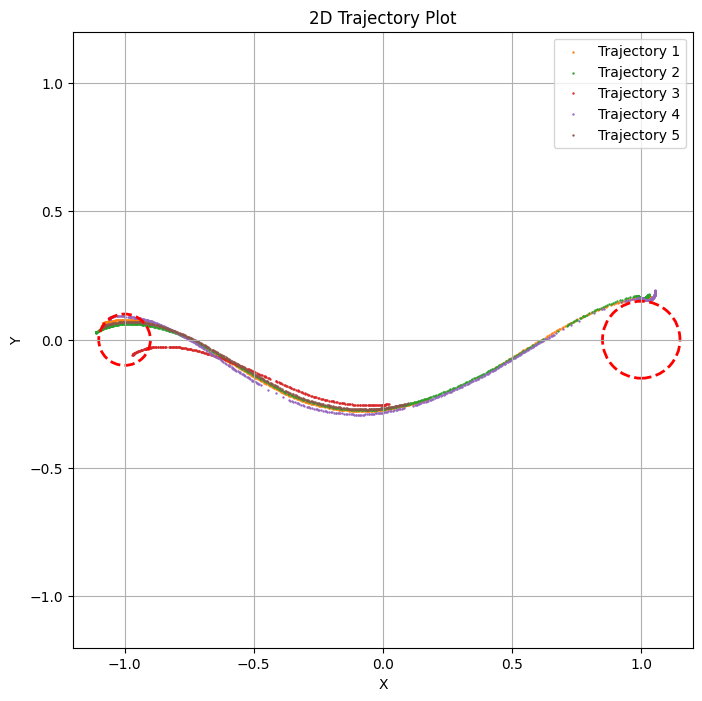

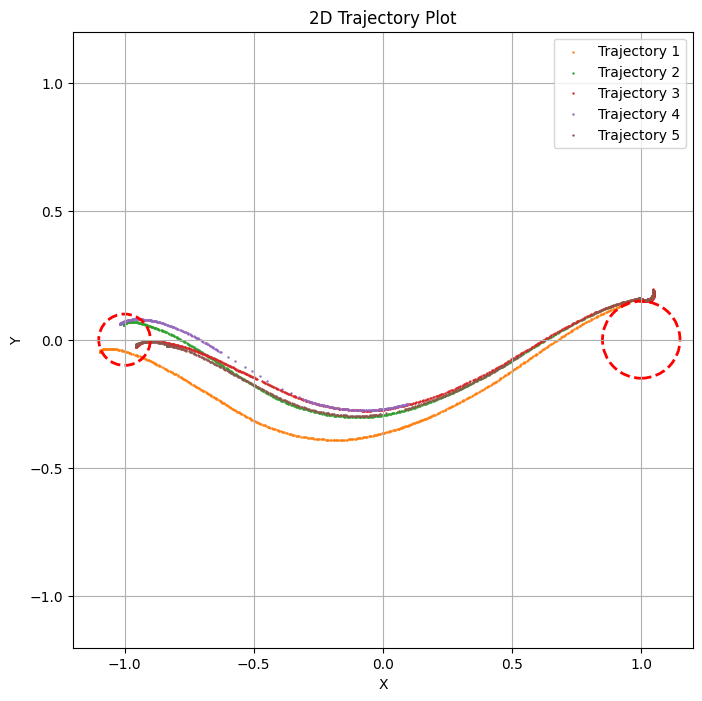

In [69]:
# Plot each trajectory

for j in range(5):
        plt.figure(figsize=(8, 8))


        for i in range(1, 6):
                data = np.load(f'./trajectories/trajectory_ExpD3_64_128_2_{j}_{i}.npz')
                pose = data['Trajectory']
                x = pose[:, 0]
                y = pose[:, 1]
                plt.scatter(x, y, label=f'Trajectory {i}', marker='o', s=0.5, color=f'C{i}')  # Plot each trajectory


        # Plot the circle
        circle = plt.Circle((-1, 0), 0.1, color='r', fill=False, linewidth=2, linestyle='--')  # Circle with center (-0.9, 0) and radius 0.1
        plt.gca().add_patch(circle)

        # Plot the circle
        circle = plt.Circle((1, 0), 0.15, color='r', fill=False, linewidth=2, linestyle='--')  # Circle with center (1, 0) and radius 0.15
        plt.gca().add_patch(circle)

        # Add labels and title
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('2D Trajectory Plot')
        plt.grid(True)
        plt.legend()
        plt.xlim(-1.2, 1.2)
        plt.ylim(-1.2, 1.2)

        # Show the plot
        plt.show()